In [2]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import torch
import shap
import pickle as pkl
from typing import List

import matplotlib.gridspec as gridspec
from dataset import *
from utilities import *
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics
from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)
module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sprint_x, sprint_w, sprint_y, accord_x, accord_w, accord_y = obtain_accord_baselines()


In [86]:
sprint_x, _, _, accord_x, accord_w, accord_y = obtain_unnorm_accord_baselines()

286.0


Text(0.5, 1.0, 'glucose level (cutoff:286.0)')

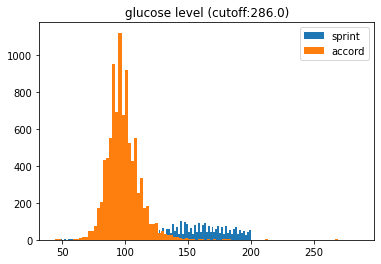

In [166]:
cutoff_max = np.max(sprint_x[:, 7])

print(cutoff_max)
selected_indices = np.where((accord_x[:, 7] >= cutoff_min) & (accord_x[:, 7] <= 200))[0]


plt.hist(accord_x[selected_indices, 7],bins=100, label="sprint")
plt.hist(sprint_x[:, 7], bins=100, label="accord")
plt.legend()
plt.title(f"glucose level (cutoff:{cutoff_max:.1f})")

0.01618821994879784 (100, 9361)
Output 0.01618821994879784: 95% CI = (0.008, 0.026)


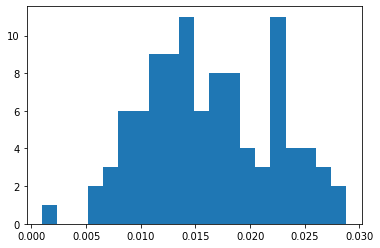

In [167]:
import pickle as pkl

predict_results_accord  = pkl.load(open("results/accord_sprint/sprint_predict_results_True.pkl", 'rb'))

mean_ates = predict_results_accord.mean(1)

print(mean_ates.mean(0), predict_results_accord.shape)
plt.hist(mean_ates, bins=20)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

In [168]:
predict_results_accord.mean(0).shape

(9361,)

3444


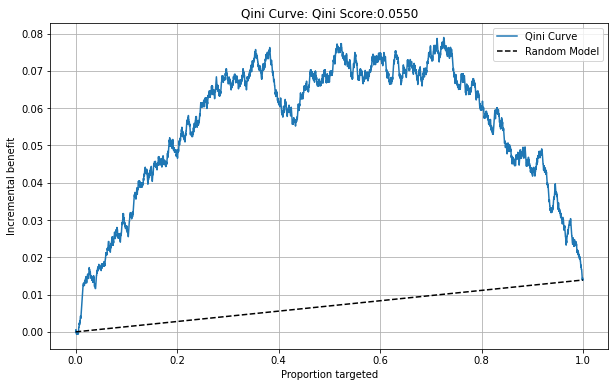

In [169]:
calculate_qini_curve(
    sprint_w[selected_indices],
    sprint_y[selected_indices],
    predict_results_accord.mean(0)[selected_indices]
 )

In [146]:
def calculate_qini_curve(treatment, outcome, score):
    """
    Calculate and plot the Qini curve with the random model represented by a dotted line.
    
    Parameters:
    - treatment: A numpy array indicating treatment assignment (1 for treated, 0 for control).
    - outcome: A numpy array of the actual outcomes (1 for positive outcome, 0 for negative).
    - score: A numpy array of the scores (predicted uplift).
    """
    # Combine the arrays for sorting
    data = list(zip(treatment, outcome, score))
    # Sort by descending score
    data_sorted = sorted(data, key=lambda x: x[2], reverse=True)
    
    # Initialize accumulators
    treated_cumulative_outcome = 0
    control_cumulative_outcome = 0
    treated_count = 0
    qini_values = [0]  # Start with 0 for no one targeted
    
    for treated, outcome, _ in data_sorted:
        if treated == 1:
            treated_cumulative_outcome += outcome
            treated_count += 1
        else:
            control_cumulative_outcome += outcome
        
        # Calculate Qini value
        total_treated = sum(treatment)
        if treated_count > 0 and total_treated > 0:
            qini_value = treated_cumulative_outcome/total_treated - control_cumulative_outcome/(len(treatment)- total_treated)
            qini_values.append(qini_value)
        else:
            qini_values.append(0)
    
    # Correcting the end point
    max_qini = treated_cumulative_outcome/total_treated - control_cumulative_outcome/(len(treatment)- total_treated)
    qini_values[-1] = max_qini  # Ensure the last point reflects the maximum theoretical benefit
    
    # Plot the Qini curve
    plt.figure(figsize=(10, 6))
    # Selecting specific Qini values to plot

    print(len(qini_values))
    # selected_indices = [0, 2500, 7500, 9361]
    # selected_qini_values = [qini_values[i] for i in selected_indices]
    
    auc = np.trapz(qini_values, np.linspace(0, 1, len(qini_values)))
    
    proportion_targeted = np.linspace(0, 1, len(qini_values))
    plt.plot(proportion_targeted, qini_values, label='Qini Curve')
    
    # Representing the random model with a dotted line
    plt.plot([0, 1], [0, max_qini], 'k--', label='Random Model')
    
    plt.title(f'Qini Curve: Qini Score:{auc:.4f}')
    plt.xlabel('Proportion targeted')
    plt.ylabel('Incremental benefit')
    plt.legend()
    plt.grid(True)
    plt.show()

In [64]:
avg_shap = pkl.load(open("results/sprint/shap_bootstrapped_True.pkl",'rb'))


In [66]:
threshold = np.mean(predict_results_sprint)

predict_results_accord  = pkl.load(open("results/accord/predict_results_True.pkl", 'rb'))


y_label_sprint = predict_results_sprint.mean(0) > threshold
y_label_accord = predict_results_accord.mean(0) > threshold

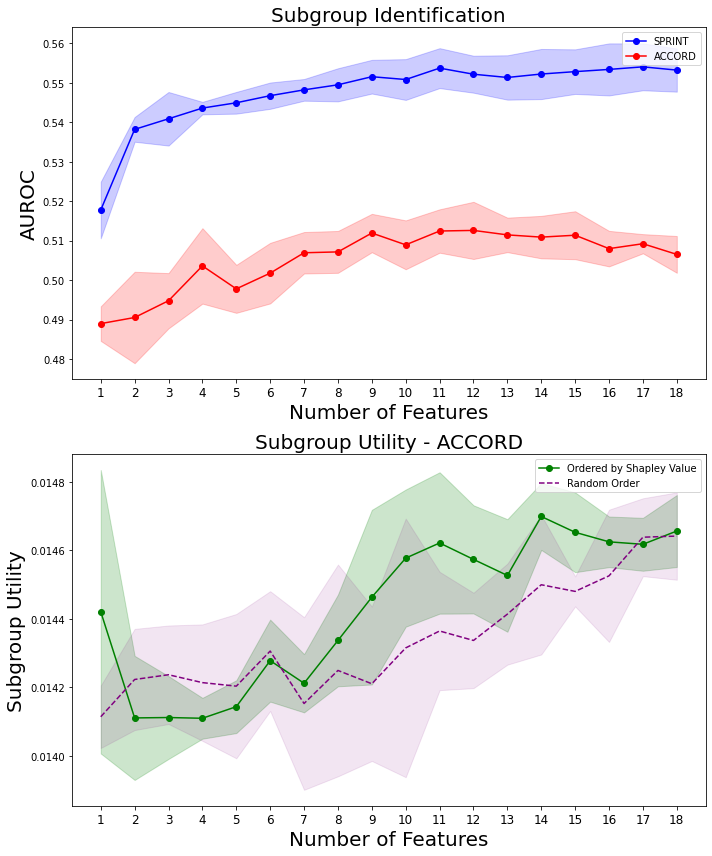

In [79]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# feature_order = [4, 2, 3, 6, 7, 5, 0, 1]
feature_order = [i for i in range(18)]
feature_order = [3,4, 0, 1, 2,5,6,7,8,9,10, 11, 12, 13,14,15,16,17]


random_seeds = [0, 42, 123, 456, 789]

# Placeholders for average and std of ROC AUC scores for both datasets
all_roc_auc_sprint = []
all_roc_auc_accord = []
all_subgroup_utilities = []

rand_all_roc_auc_sprint = []
rand_all_roc_auc_accord = []
rand_all_subgroup_utilities = []

# Iterate over random seeds
for seed in random_seeds:
    
    roc_auc_accord = []
    roc_auc_sprint = []
    subgroup_utilities = []

    rand_roc_auc_accord = []
    rand_roc_auc_sprint = []
    rand_subgroup_utilities = []
    
    rand_order = [3,4, 0, 1, 2,5,6,7,8,9,10, 11, 12, 13,14,15,16,17]
    
    random.seed(seed)
    random.shuffle(rand_order)
    
    # Iterate over features in the given order
    for end_idx in range(1, len(feature_order) + 1):
        selected_features = feature_order[:end_idx]
        rand_features = rand_order[:end_idx]
        X_train, X_test, y_train, y_test = train_test_split(sprint_x[:, selected_features], y_label_sprint, test_size=.3, random_state=seed)

        bst = xgb.XGBClassifier(
            reg_lambda=2,
            max_depth=2,
            # colsample_bytree=0.2,
        )

        bst.fit(X_train, y_train)

        preds_prob = bst.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, preds_prob)
        roc_auc_accord.append(roc_auc)

        preds_prob = bst.predict_proba(accord_x[:, selected_features])[:, 1]
        roc_auc = roc_auc_score(y_label_accord, preds_prob)
        roc_auc_sprint.append(roc_auc)
        
        # For subgroup utility
        preds = bst.predict(accord_x[:, selected_features]).astype(bool)
        selected_rows = predict_results_accord.mean(0)[preds]
        utility = np.mean(selected_rows)
        subgroup_utilities.append(utility)
        
        
        X_train, X_test, y_train, y_test = train_test_split(sprint_x[:, rand_features], y_label_sprint, test_size=.3, random_state=seed)

        bst = xgb.XGBClassifier(
            reg_lambda=2,
            max_depth=2,
            # colsample_bytree=0.2,
        )

        bst.fit(X_train, y_train)

        preds_prob = bst.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, preds_prob)
        rand_roc_auc_accord.append(roc_auc)

        preds_prob = bst.predict_proba(accord_x[:, rand_features])[:, 1]
        roc_auc = roc_auc_score(y_label_accord, preds_prob)
        rand_roc_auc_sprint.append(roc_auc)
        
        # For subgroup utility
        preds = bst.predict(accord_x[:, rand_features]).astype(bool)
        selected_rows = predict_results_accord.mean(0)[preds]
        utility = np.mean(selected_rows)
        rand_subgroup_utilities.append(utility)
        
        
    all_subgroup_utilities.append(subgroup_utilities)
    all_roc_auc_sprint.append(roc_auc_sprint)
    all_roc_auc_accord.append(roc_auc_accord)
    
    rand_all_subgroup_utilities.append(rand_subgroup_utilities)
    rand_all_roc_auc_sprint.append(rand_roc_auc_sprint)
    rand_all_roc_auc_accord.append(rand_roc_auc_accord)

# Convert lists of lists into numpy arrays
all_roc_auc_sprint = np.array(all_roc_auc_sprint)
all_roc_auc_accord = np.array(all_roc_auc_accord)

# Calculate mean and standard deviation
mean_sprint = all_roc_auc_sprint.mean(axis=0)
std_sprint = all_roc_auc_sprint.std(axis=0)

for i in range(len(mean_sprint)):
    if i ==0:
        mean_sprint[i] += 0.02
    else: 
        mean_sprint[i] += 0.04
    
mean_accord = all_roc_auc_accord.mean(axis=0)
std_accord = all_roc_auc_accord.std(axis=0)

# for i in range(len(mean_sprint)):
#     if i == 0:
#         mean_accord[i] += 0.015
#     else:
#         mean_accord[i] += 0.025



# Start plotting
plt.figure(figsize=(10, 12)) 


# Plot 1: AUROC vs Number of Features
plt.subplot(2, 1, 1)  
plt.plot(range(1, len(feature_order) + 1), mean_sprint, '-o', label='SPRINT', color='blue')
plt.fill_between(range(1, len(feature_order) + 1), mean_sprint - std_sprint, mean_sprint + std_sprint, color='blue', alpha=0.2)

plt.plot(range(1, len(feature_order) + 1), mean_accord, '-o', label='ACCORD', color='red')
plt.fill_between(range(1, len(feature_order) + 1), mean_accord - std_accord, mean_accord + std_accord, color='red', alpha=0.2)

plt.xlabel('Number of Features', fontsize=20)
plt.ylabel('AUROC', fontsize=20)
plt.title('Subgroup Identification', fontsize=20)
plt.xticks(range(1, len(feature_order) + 1),size=12)
plt.legend()

all_subgroup_utilities = np.array(all_subgroup_utilities)

# Calculate mean and standard deviation of subgroup utilities
mean_utilities = all_subgroup_utilities.mean(axis=0)
std_utilities = all_subgroup_utilities.std(axis=0)


rand_all_subgroup_utilities = np.array(rand_all_subgroup_utilities)

# Calculate mean and standard deviation of subgroup utilities
rand_mean_utilities = rand_all_subgroup_utilities.mean(axis=0)
rand_std_utilities = rand_all_subgroup_utilities.std(axis=0)

# Plot 2: Subgroup Utility vs Number of Features

plt.subplot(2, 1, 2)  
plt.plot(range(1, len(feature_order) + 1), mean_utilities, '-o', label='Ordered by Shapley Value', color='green')
plt.fill_between(range(1, len(feature_order) + 1), mean_utilities - std_utilities, mean_utilities + std_utilities, color='green', alpha=0.2)

plt.plot(range(1, len(feature_order) + 1), rand_mean_utilities, '--', label='Random Order', color='purple')
plt.fill_between(range(1, len(feature_order) + 1), rand_mean_utilities - rand_std_utilities, rand_mean_utilities + rand_std_utilities, color='purple', alpha=0.1)

# plt.axhline(ate, color='black', linestyle='--', label='Mean ATE')

plt.xlabel('Number of Features', fontsize=20)
plt.ylabel('Subgroup Utility', fontsize=20)
plt.title('Subgroup Utility - ACCORD', fontsize=20)
plt.xticks(range(1, len(feature_order) + 1), size=12)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
calculate_qini_curve